<a href="https://colab.research.google.com/github/karoldem/Rekrutacja_2023/blob/main/Rekrutacja_ko%C5%82o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First get our data:

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

df = pd.read_csv('../../dane.csv')
df['CryoSleep'] = df['CryoSleep'].astype('bool')
df['VIP'] = df['VIP'].astype('bool')
df[['Deck','CabinNum', 'Side']] = df["Cabin"].str.split("/", n = 2, expand = True)
df = df.drop('Cabin', axis=1)
df = df.drop('PassengerId', axis=1)
df = df.drop('Name', axis=1)

I expect all expenses to be "alike", so...

In [22]:
expenses = ['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categories = ['HomePlanet', 'Destination', 'Deck', 'Side', 'CryoSleep', 'VIP', 'Transported']
nonBinaryCategories = ['HomePlanet', 'Destination', 'Deck']

In [23]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Looks like 1% is making spending most of money here.

In [24]:
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNum,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,98,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1499,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,1500,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,608,S


Yes, not only 1% is spending most of money, but also seems like even touching certain area is very predictive.

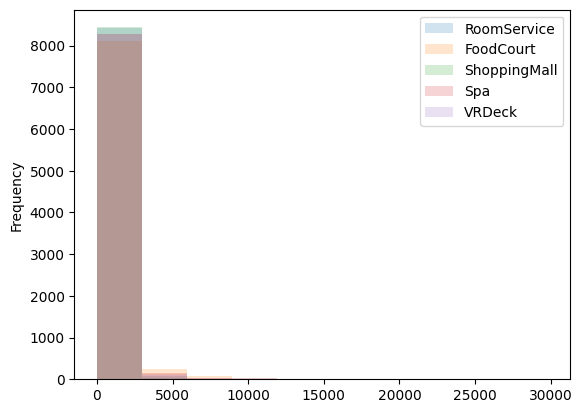

In [25]:
df[expenses].plot.hist(alpha = 0.2);

As we see, we need a logspace.

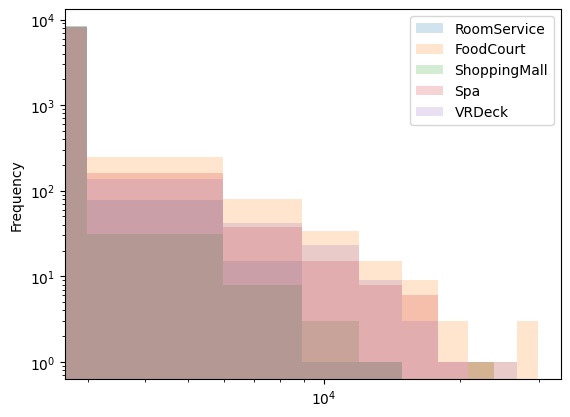

In [26]:
df[expenses].plot.hist(alpha = 0.2, logy=True, logx = True);

Now it is clearly visible that we need to get zeros into another feature and use logscale.

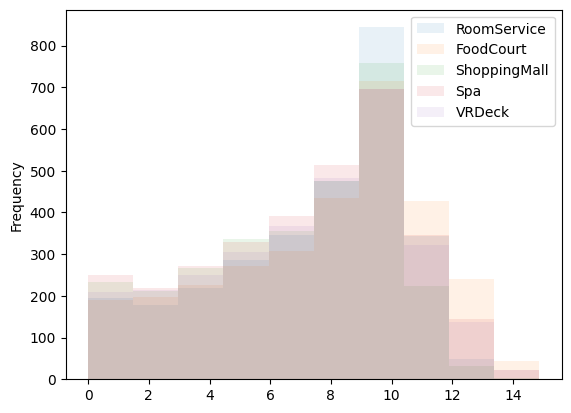

In [27]:
df1 = df.copy()

for i in expenses:
    df1[i + 'Bool'] = df1[i] > 0
    df1.loc[df1[i] == 0, [i]] = None
    df1[i] = np.log2(df1[i])

df1[expenses].plot.hist(alpha = 0.1);

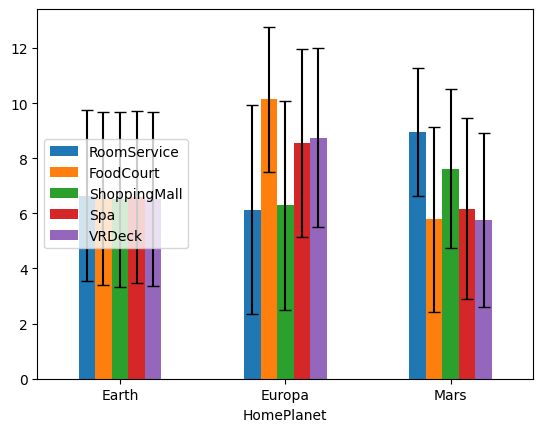

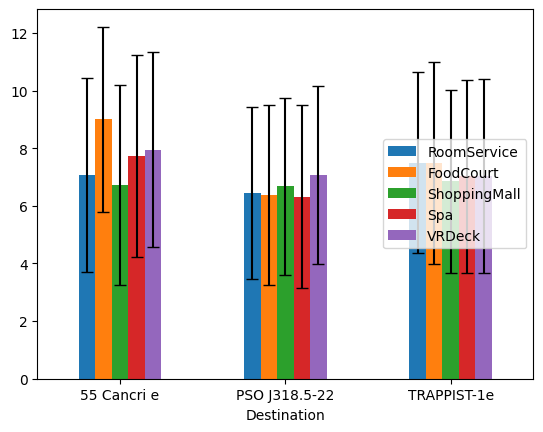

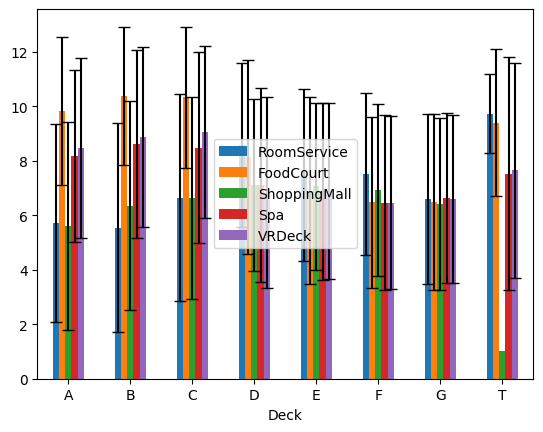

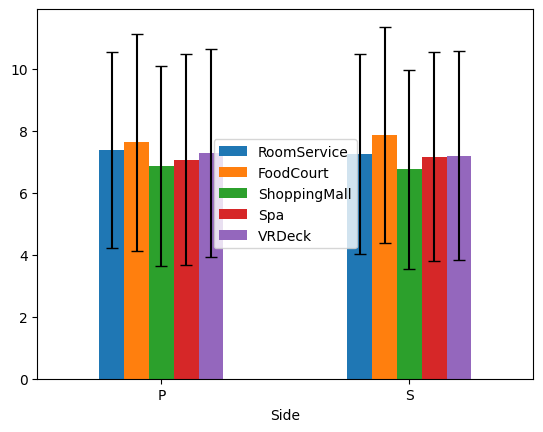

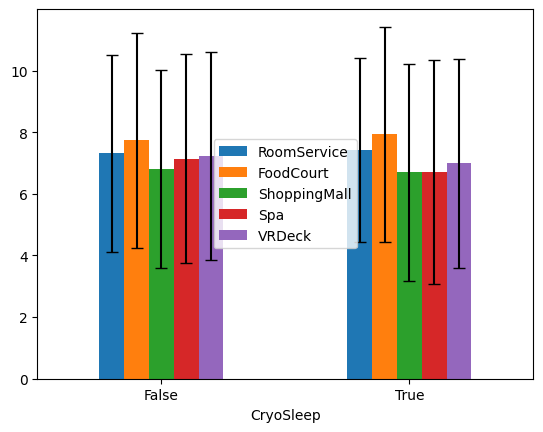

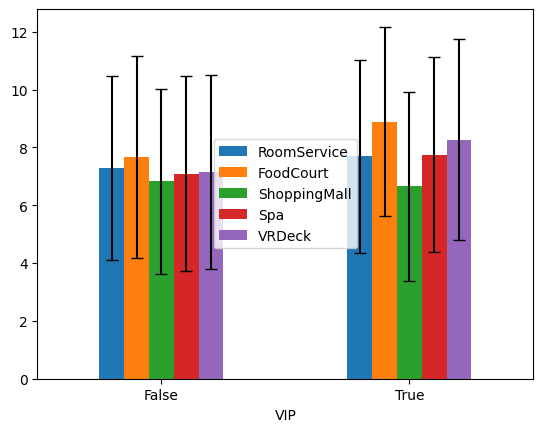

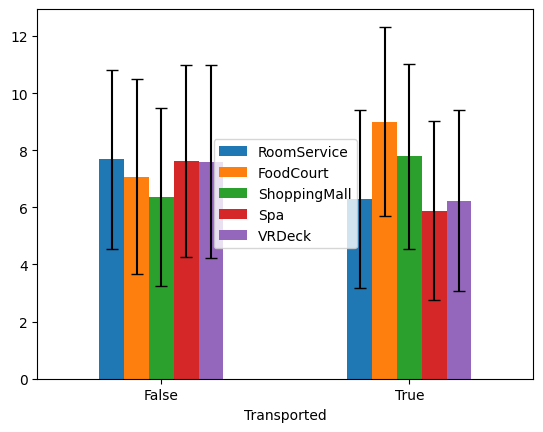

In [28]:
for i in categories:
    fig, ax = plt.subplots()
    gb = df1[([i] + expenses)].groupby([i])
    gb.mean().plot.bar(yerr=gb.std(), ax=ax, capsize=4, rot=0);

OK, now data looks nice, but there's a lot of NaNs in it. Let's put them back.

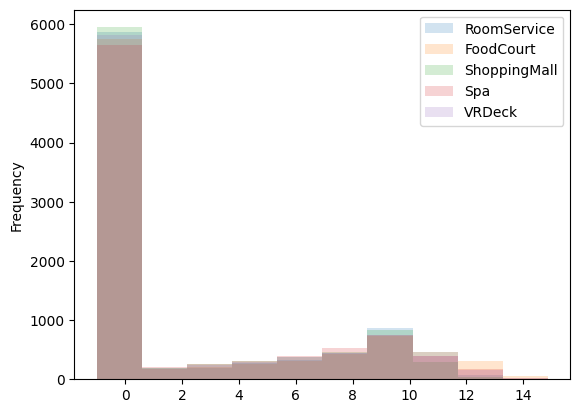

In [29]:
df1 = df.copy()
for i in expenses:
    df1[i + 'Bool'] = df1[i] > 0
    df1.loc[df1[i] == 0, [i]] = None
    df1[i] = np.log2(df1[i])
    df1.loc[df1[i].isna(), [i]] = -1

df1[expenses].plot.hist(alpha = 0.2);

Let's look at side of ship.

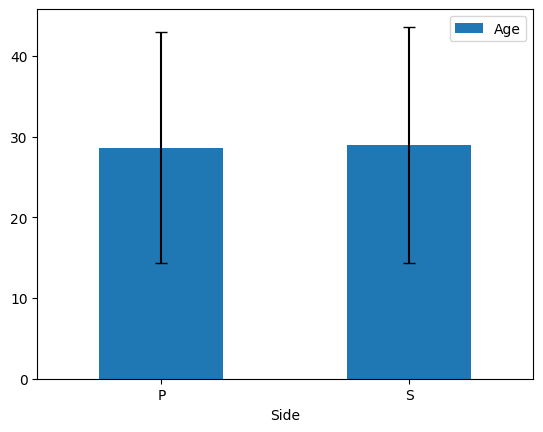

In [30]:
fig, ax = plt.subplots()
gb = df1[['Side', 'Age']].groupby(['Side'])
gb.mean().plot.bar(yerr=gb.std(), ax=ax, capsize=4, rot=0);

Let's remove it from dataframe for now.

In [31]:
df1 = df1.drop('Side', axis=1)
categories.remove('Side')

Now look at categorical data.

In [32]:
i = 0
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,HomePlanet,Transported
1,Europa,0.658846
2,Mars,0.523024
0,Earth,0.423946


In [33]:
i = 1
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,Destination,Transported
0,55 Cancri e,0.610000
1,PSO J318.5-22,0.503769
2,TRAPPIST-1e,0.471175


In [34]:
i = 2
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,Deck,Transported
1,B,0.734275
2,C,0.680054
6,G,0.516217
0,A,0.496094
5,F,0.439871
3,D,0.433054
4,E,0.357306
7,T,0.200000


In [35]:
i = 3
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,CryoSleep,Transported
1,True,0.795636
0,False,0.328921


In [36]:
i = 4
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,VIP,Transported
0,False,0.506332
1,True,0.447761


OK, data looks nice. Let's make some machine learning.

In [37]:
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(df1[nonBinaryCategories])
temp = pd.DataFrame(encoded, columns=np.hstack(encoder.categories_))
df2 = pd.concat((df1, temp), axis=1).drop(nonBinaryCategories, axis=1)
df2 = df2.loc[:, df2.columns.notna()]
df2 = df2.dropna()

xTrain, xTest, yTrain, yTest = train_test_split(df2.values, df2['Transported'].values, test_size = 0.2)
model = DecisionTreeClassifier()
model.fit(xTrain, yTrain)
confusion_matrix(yTest, model.predict(xTest))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[832,   0],
       [  0, 832]])

Wow, that was quick. I needed to make sure that I didn't mess anything up and I made several trials and errors to see how little data do I need and this is edge case. As seen below seems like with (in order of magnitude) 10 datapoints we can make 99,99% accurate prediction 90% of times.

In [44]:
counter = 0
for _ in range(1000):
    xTrain, xTest, yTrain, yTest = train_test_split(df2.values, df2['Transported'].values, test_size = 0.99875)
    model = DecisionTreeClassifier()
    model.fit(xTrain, yTrain)
    cm = confusion_matrix(yTest, model.predict(xTest))
    if cm[0][1] != 0 or cm[1][0] != 0 :
        counter+=1
        print(cm[0], cm[1], counter)

print(len(xTrain))

[2711 1413] [2842 1343] 1
[1649 2478] [ 496 3686] 2
[1902 2224] [ 890 3293] 3
[3498  626] [1734 2451] 4
[2204 1923] [ 855 3327] 5
[3446  676] [3551  636] 6
[3498  626] [1734 2451] 7
[3828  293] [3785  403] 8
[1614 2514] [1516 2665] 9
[3207  916] [3288  898] 10
[1647 2478] [ 504 3680] 11
[1682 2442] [ 572 3613] 12
[2204 1923] [ 855 3327] 13
[2088 2037] [ 800 3384] 14
[1902 2224] [ 890 3293] 15
[2204 1923] [ 855 3327] 16
[2072 2051] [ 739 3447] 17
[2089 2037] [ 800 3383] 18
[1744 2381] [ 596 3588] 19
[1788 2338] [ 853 3330] 20
[ 539 3588] [ 383 3799] 21
[2076 2051] [ 739 3443] 22
[1955 2172] [ 669 3513] 23
[1444 2682] [ 381 3802] 24
[2202 1923] [ 855 3329] 25
[3497  626] [1734 2452] 26
[ 374 3753] [ 389 3793] 27
[1385 2742] [ 354 3828] 28
[1114 3014] [ 223 3958] 29
[1121 3007] [ 212 3969] 30
[1900 2224] [ 890 3295] 31
[3501  626] [1734 2448] 32
[1719 2405] [ 541 3644] 33
[3500  626] [1734 2449] 34
[1866 2260] [2084 2099] 35
[1322 2806] [ 310 3871] 36
[2881 1241] [2979 1208] 37
[3499  626